In [13]:
import warnings
warnings.filterwarnings('ignore')
import torch
import timm
import torch.nn as nn
from transformers import Dinov2Model, AutoImageProcessor
from pytorch_grad_cam.utils.image import deprocess_image
from gradcam_util import *

In [14]:
class Dinov2BinaryClassifier(nn.Module):
    def __init__(
        self,
        backbone_name: str = "facebook/dinov2-small",
        hidden_dim: int = 512,
        dropout_prob: float = 0.4,
    ):
        """
        Param:
            - backbone_name: Hugging Face Dinov2 
            - hidden_dim: hidden dim
            - dropout_prob: dropout ratio
        """
        super().__init__()
        # 1) data preprocessing (check next cell for deatils)
        self.processor = AutoImageProcessor.from_pretrained(backbone_name)

        # 2) load pretrained weight
        self.backbone = Dinov2Model.from_pretrained(backbone_name)

        # 3) Classification Head：CLS token -> hidden_dim -> ReLU -> Dropout
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.config.hidden_size, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dim, 1),  # BCE 1 dim output
        )

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        """
        Param:
            - pixel_values: shape = (batch_size, 3, image_size, image_size),
        Output:
            - logits: shape = (batch_size, 2) raw score
        """
        # 1) send input into Dinov2 backbone,get last_hidden_state
        #    outputs.last_hidden_state = (batch_size, seq_len, hidden_size)，
        #    seq_len = patch + 1（CLS token）
        outputs = self.backbone(pixel_values=pixel_values)
        last_hidden = outputs.last_hidden_state  # (B, seq_len, hidden)

        # 2) get CLS token：last_hidden[:, 0, :]
        cls_token = last_hidden[:, 0, :]  # (B, hidden_size)

        # 3) sends CLS toekn
        logits = self.classifier(cls_token)  # (B, 2)
        return logits

In [15]:
class VitBinaryClassifier(nn.Module):
    def __init__(
        self,
        backbone_name: str = 'tiny_vit_21m_224.dist_in22k_ft_in1k',
        hidden_dim: int = 512,
        dropout_prob: float = 0.4,
    ):
        """
        Param:
            - backbone_name: Hugging Face Vit 
            - hidden_dim: hidden dim
            - dropout_prob: dropout ratio
        """
        super().__init__()
        # 1) data preprocessing (check next cell for deatils)
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0)
        hidden_size = self.backbone.head.in_features

        # 2) Classification Head：CLS token -> hidden_dim -> ReLU -> Dropout
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dim, 1),  # BCE 1 dim output
        )

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        """
        Param:
            - pixel_values: shape = (batch_size, 3, image_size, image_size),
        Output:
            - logits: shape = (batch_size, 2) raw score
        """
        # 1) Run backbone (e.g., TinyViT from timm), output shape: (B, seq_len, hidden_size)
        cls_token = self.backbone(pixel_values)

        # 2) Apply classifier head
        logits = self.classifier(cls_token)  # (B, 1)
        return logits  # squeeze to (B,)

In [16]:
class Resnet34BinaryClassifier(nn.Module):
    def __init__(
        self,
        backbone_name: str = 'resnet34.a1_in1k',
        hidden_dim: int = 512,
        dropout_prob: float = 0.5,
    ):
        """
        Param:
            - backbone_name: Hugging Face Dinov2 
            - hidden_dim: hidden dim
            - dropout_prob: dropout ratio
        """
        super().__init__()
        # 1) Load pretrained ResNet18 backbone (no classifier head)
        self.backbone = timm.create_model(backbone_name, pretrained=False, num_classes=0)

        # 2) Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.num_features, hidden_dim),  # get output dim from backbone
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dim, 1),  # binary output
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [20]:
# model = Dinov2BinaryClassifier(hidden_dim=256, dropout_prob=0.5)  
# model.load_state_dict(torch.load("results/Dinov2_w_pretrain/dinov2_small_256_.5_finalv2.pth"))
# model.eval()
# model.load_state_dict(torch.load("results/Dinov2_w_pretrain/dinov2_small_256_.5_finalv1.pth", map_location=torch.device('cpu')))

model = VitBinaryClassifier(hidden_dim=256, dropout_prob=0.5)  
model.load_state_dict(torch.load("results/TinyVit_w_pretrain_newdata/tinyvit_256_.5_final2.pth", map_location=torch.device('cpu')))
model.eval()
# # model.load_state_dict(torch.load("results/Dinov2_w_pretrain/dinov2_small_256_.5_finalv2.pth"))

# model = Resnet34BinaryClassifier(hidden_dim=256, dropout_prob=0.5)  
# model.load_state_dict(torch.load("results/Resnet34_w_pretrain_newdata/Resnet34_.pth"))
# model.eval()
# model.load_state_dict(torch.load("results/Resnet34_w_pretrain/Resnet34_final.pth", map_location=torch.device('cpu')))

VitBinaryClassifier(
  (backbone): TinyVit(
    (patch_embed): PatchEmbed(
      (conv1): ConvNorm(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (act): GELU(approximate='none')
      (conv2): ConvNorm(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stages): Sequential(
      (0): ConvLayer(
        (blocks): Sequential(
          (0): MBConv(
            (conv1): ConvNorm(
              (conv): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): ConvNorm(
              (conv): Conv2d(384

In [21]:
# results = batch_hires_cam(model_name="dinov2", model=model, batch_dir="ClassificationDataset_label/low", exp=0.5)
results = batch_hires_cam(model_name="tinyvit", model=model, batch_dir="ClassificationDataset_label/low", exp=0.8)
# results = batch_grad_cam(model_name="resnet", model=model, batch_dir="ClassificationDataset_label/low", exp=1)

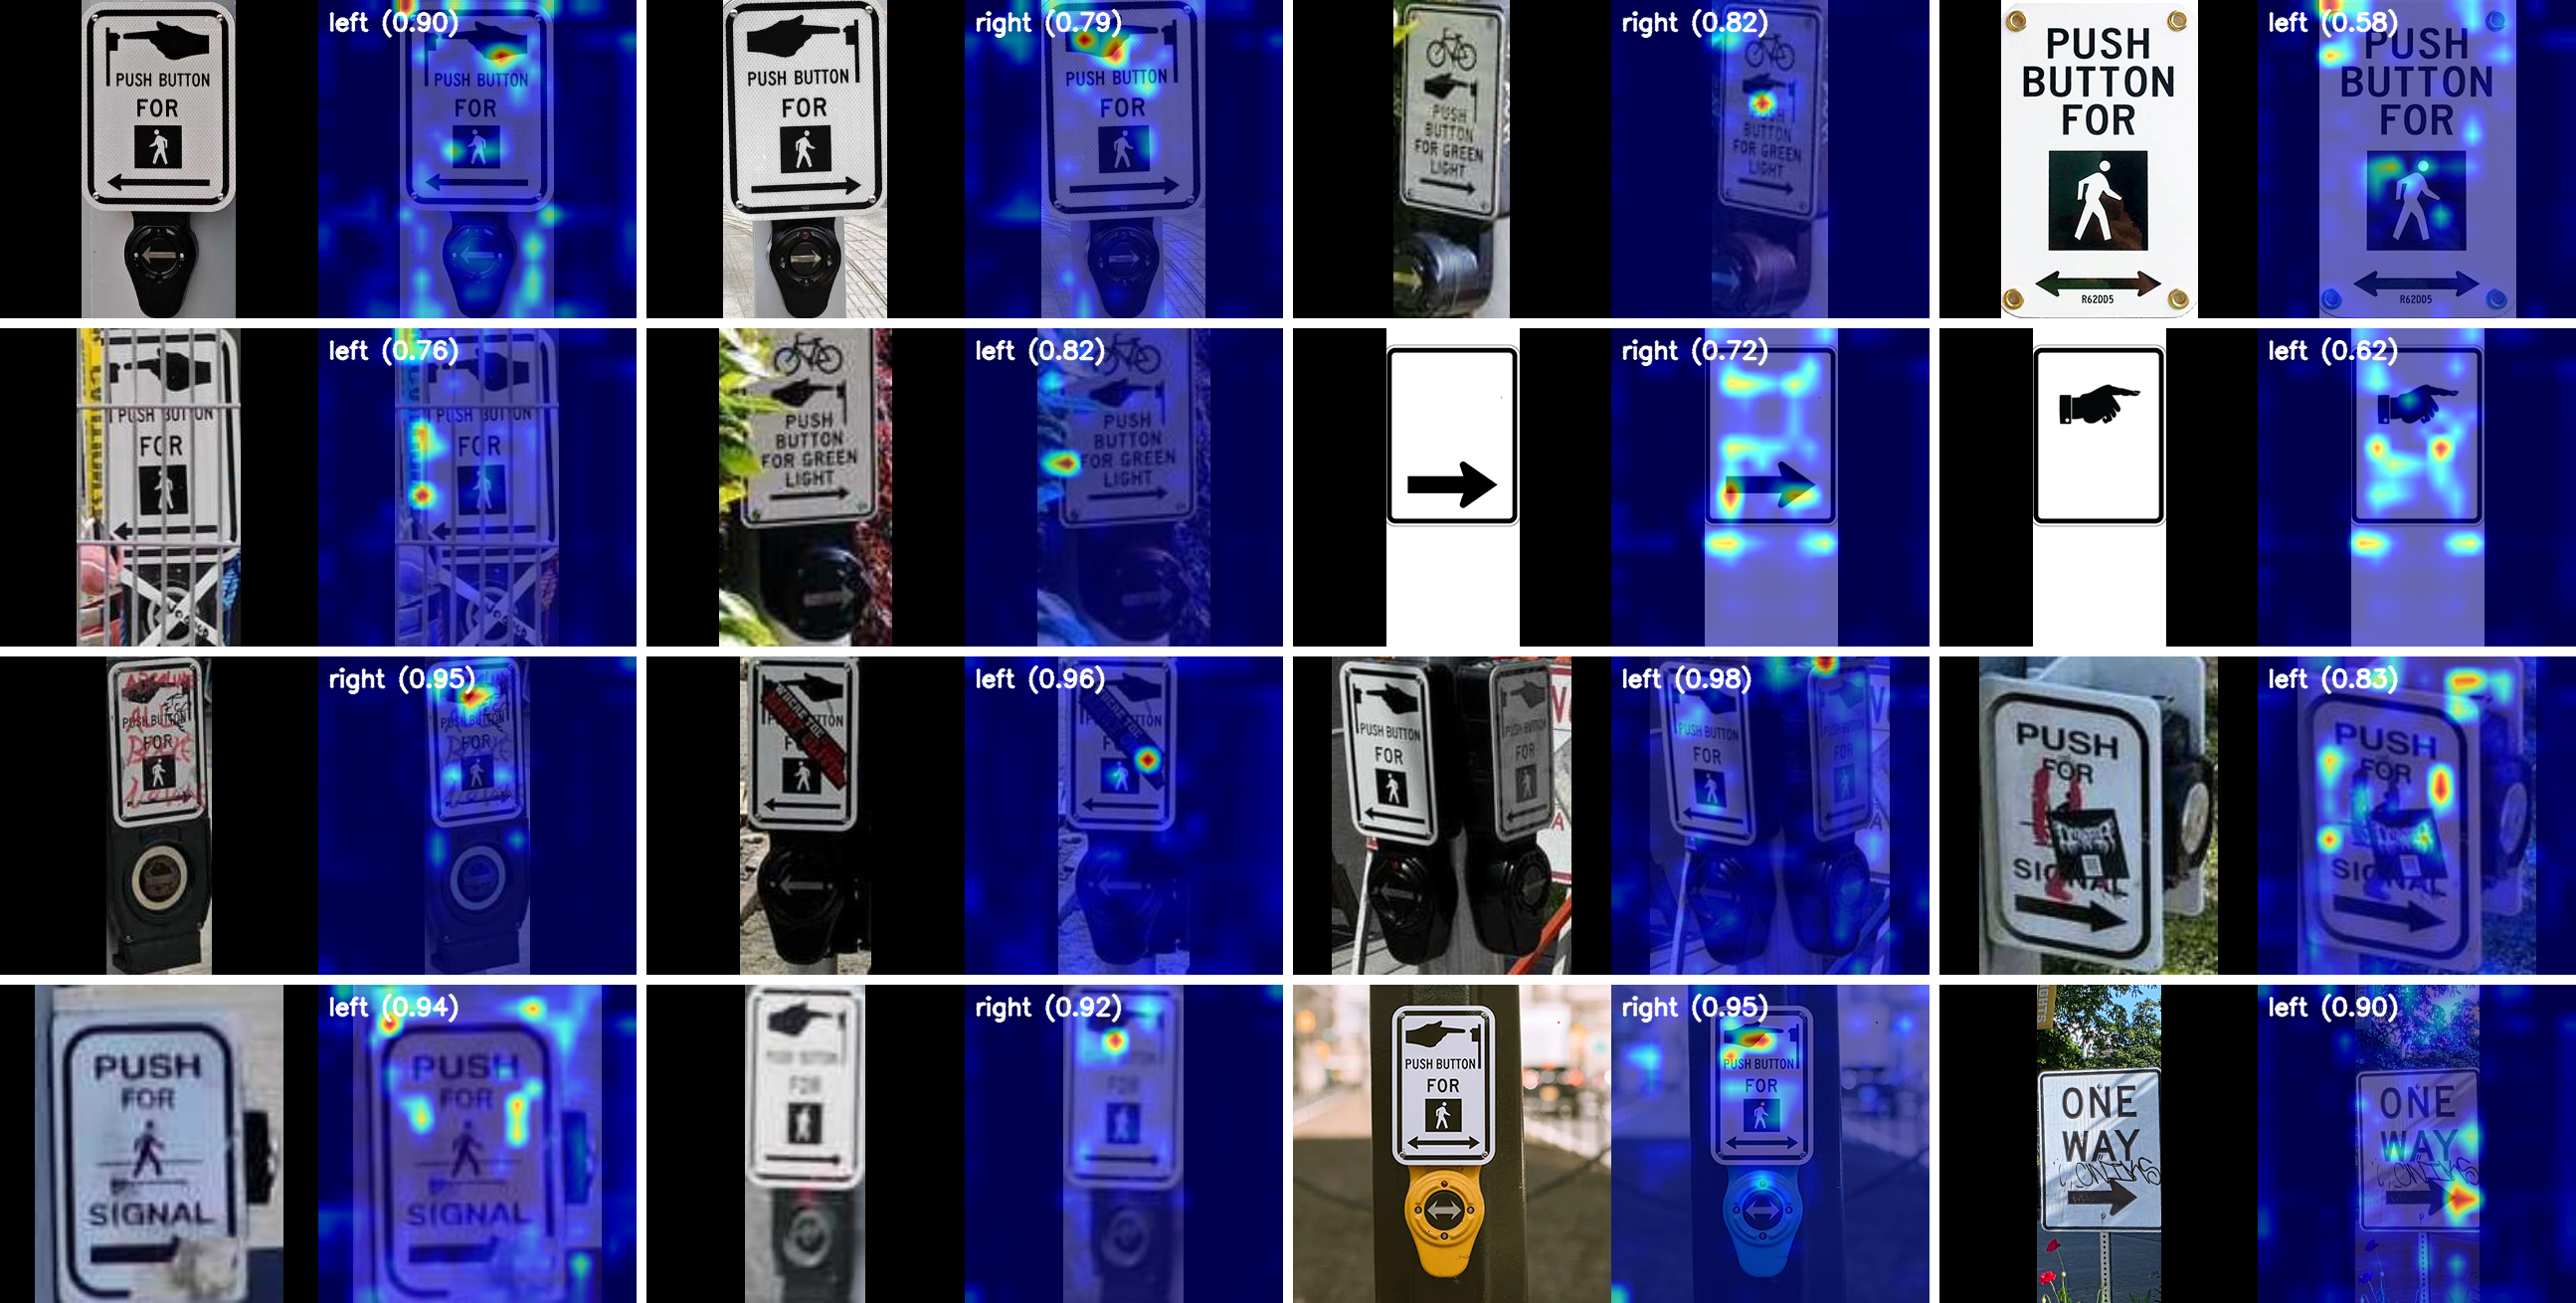

In [22]:
results

Probability before : 0.9458
Probability after  : 0.7847
Confidence increase: -16.11%


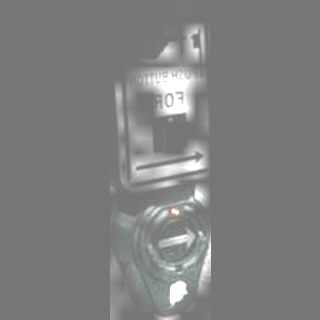

In [10]:
# from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange

# def print_confidence_change(model, input_tensor, logit_delta, target_index=1):
#     model.eval()
#     with torch.no_grad():
#         original_logits = model(input_tensor)
#         if original_logits.dim() == 2 and original_logits.size(1) > 1:
#             logit_before = original_logits[0, target_index].item()
#         else:
#             logit_before = original_logits[0].item()
#     logit_after = logit_before + logit_delta
#     prob_before = torch.sigmoid(torch.tensor(logit_before)).item()
#     prob_after = torch.sigmoid(torch.tensor(logit_after)).item()
    
#     # print(f"ogit delta         : {logit_delta:.4f}")
#     print(f"Probability before : {prob_before:.4f}")
#     print(f"Probability after  : {prob_after:.4f}")
#     print(f"Confidence increase: {100 * (prob_after - prob_before):.2f}%")

# targets = [ClassifierOutputTarget(0)]
# cam_metric = CamMultImageConfidenceChange()
# scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, dino, return_visualization=True)
# score = scores[0]
# visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
# visualization = deprocess_image(visualization)

# print_confidence_change(dino, input_tensor, logit_delta=score, target_index = 1)
# Image.fromarray(visualization)
